In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io.wavfile as wav
import sounddevice as sd
import torchaudio
from scipy.fftpack import fft, ifft
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.signal import correlate

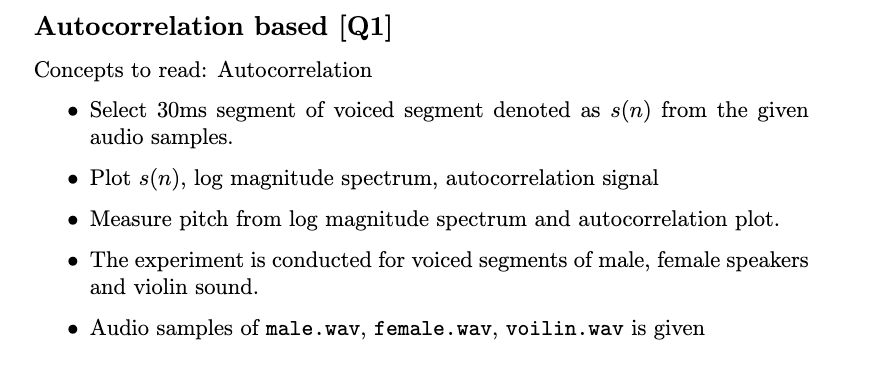

[-0.02600098 -0.01391602 -0.00186157 ... -0.0218811  -0.01168823
  0.00524902]
Results for male.wav:
Spectral Method: 133.33 Hz
Autocorrelation Method: 2004.55 Hz

[0.10443115 0.1000061  0.09771729 ... 0.14559937 0.13537598 0.1210022 ]
Results for female.wav:
Spectral Method: 466.67 Hz
Autocorrelation Method: 234.57 Hz

[-0.01364136 -0.01379395 -0.01177979 ...  0.05050659  0.04199219
  0.03256226]
Results for violin.wav:
Spectral Method: 433.33 Hz
Autocorrelation Method: 441.00 Hz



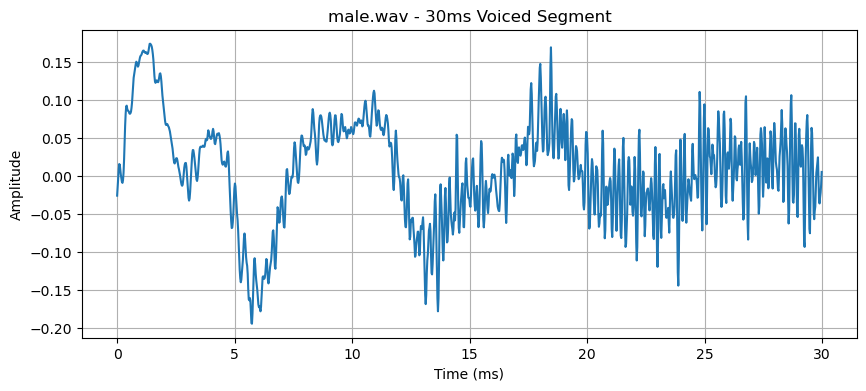

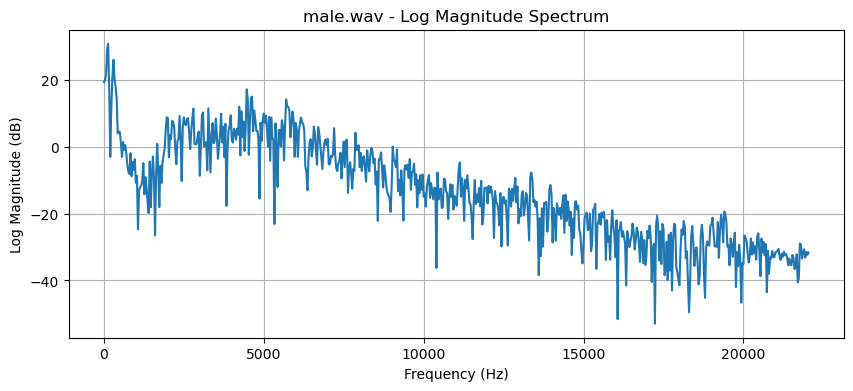

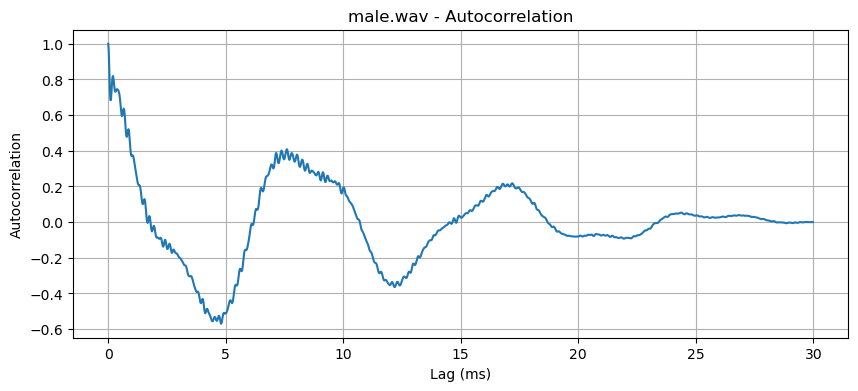

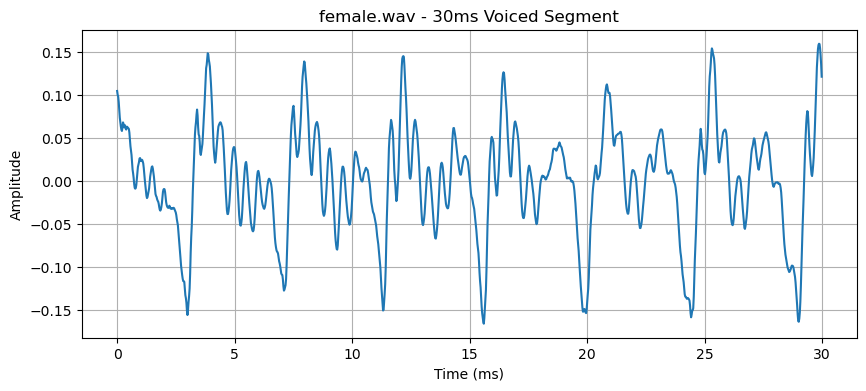

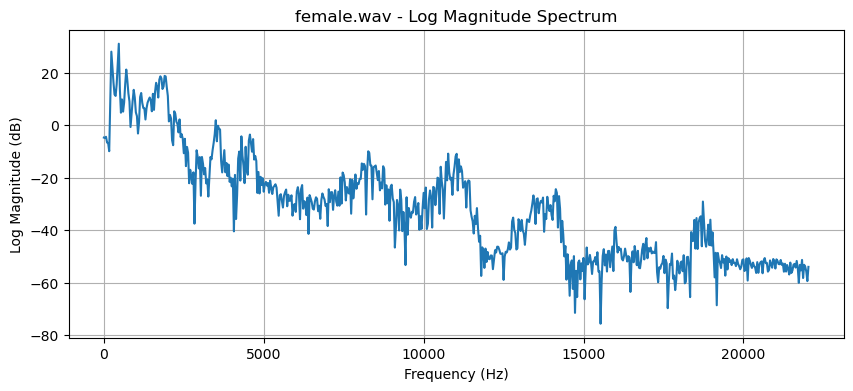

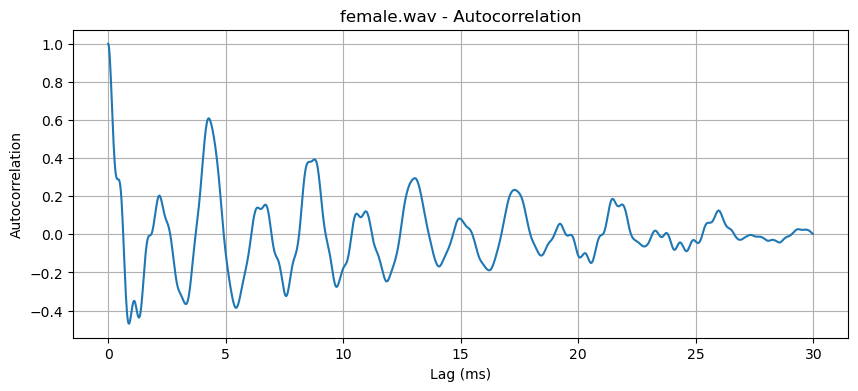

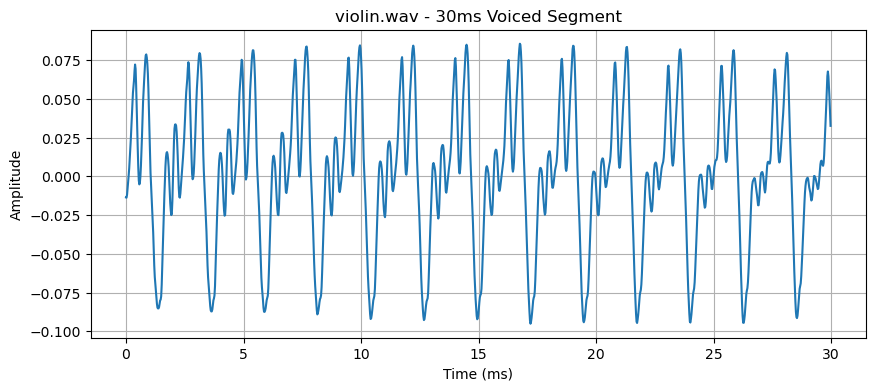

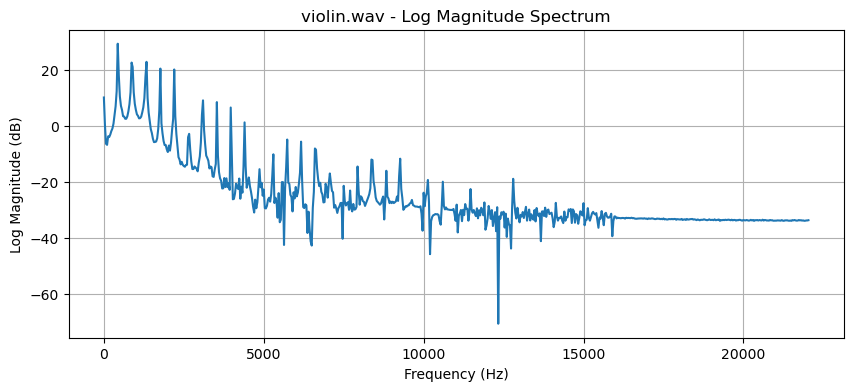

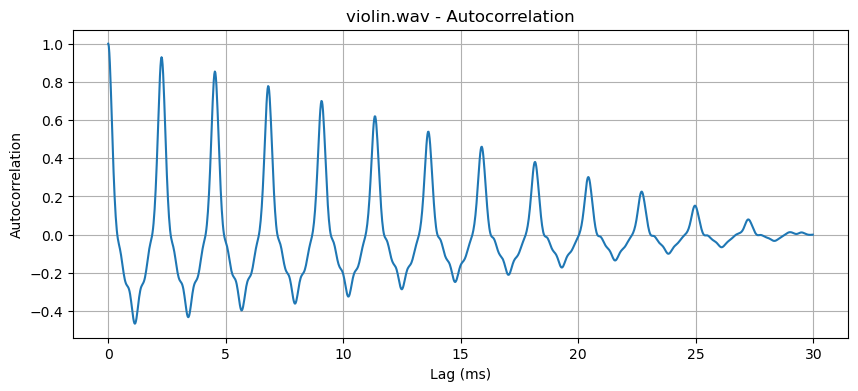

In [28]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def plot_segment(s, sr, title):
    plt.figure(figsize=(10, 4))
    time = np.arange(len(s)) / sr * 1000  # Convert to milliseconds
    plt.plot(time, s)
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(True)

def plot_spectrum(s, sr, title):
    n = len(s)
    fft = np.fft.rfft(s)
    mag = np.abs(fft)
    mag_db = 20 * np.log10(mag + 1e-10)  # Avoid log(0)
    freq = np.fft.rfftfreq(n, d=1/sr)
    plt.figure(figsize=(10, 4))
    plt.plot(freq, mag_db)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Log Magnitude (dB)')
    plt.title(title)
    plt.grid(True)

def compute_autocorr(s):
    n = len(s)
    fft = np.fft.rfft(s, n=2*n)
    autocorr = np.fft.irfft(fft * np.conj(fft))[:n]
    autocorr /= autocorr[0]  # Normalize
    return autocorr

def plot_autocorr(autocorr, sr, title):
    lags = np.arange(len(autocorr))
    time_lags = lags / sr * 1000  # Convert lags to milliseconds
    plt.figure(figsize=(10, 4))
    plt.plot(time_lags, autocorr)
    plt.xlabel('Lag (ms)')
    plt.ylabel('Autocorrelation')
    plt.title(title)
    plt.grid(True)

def get_pitch_from_spectrum(s, sr, min_freq=50, max_freq=2000):
    n = len(s)
    fft = np.fft.rfft(s)
    mag = np.abs(fft)
    freq = np.fft.rfftfreq(n, d=1/sr)
    mask = (freq >= min_freq) & (freq <= max_freq)
    valid_freq = freq[mask]
    valid_mag = mag[mask]
    if len(valid_mag) == 0:
        return 0.0
    peak_idx = np.argmax(valid_mag)
    return valid_freq[peak_idx]

def get_pitch_from_autocorr(autocorr, sr, min_freq=50, max_freq=2000):
    min_lag = max(1, int(sr / max_freq))  # Avoid zero division
    max_lag = min(len(autocorr), int(sr / min_freq))
    if min_lag >= max_lag:
        return 0.0
    autocorr_sub = autocorr[min_lag:max_lag]
    peak_lag = np.argmax(autocorr_sub) + min_lag
    return sr / peak_lag

# Process each audio file
audio_files = ['male.wav', 'female.wav', 'violin.wav']
start_times = [0.6, 0.5, 0.5]
index = 0
for file in audio_files:
    y, sr = librosa.load(file, sr=None)

    start_idx = int(start_times[index] * sr)  # Start at 0.5 seconds to avoid silence
    index = index + 1
    segment_length = int(0.03 * sr)  # 30 ms segment
    s = y[start_idx:start_idx + segment_length]
    print (s)
    # Generate plots
    plot_segment(s, sr, f'{file} - 30ms Voiced Segment')
    plot_spectrum(s, sr, f'{file} - Log Magnitude Spectrum')
    autocorr = compute_autocorr(s)
    plot_autocorr(autocorr, sr, f'{file} - Autocorrelation')
    
    # Calculate pitches
    pitch_spec = get_pitch_from_spectrum(s, sr)
    pitch_auto = get_pitch_from_autocorr(autocorr, sr)
    
    print(f'Results for {file}:')
    print(f'Spectral Method: {pitch_spec:.2f} Hz')
    print(f'Autocorrelation Method: {pitch_auto:.2f} Hz\n')

plt.show()

/var/folders/2d/mf93wtk914vbrkclc8d3hrt40000gn/T/ipykernel_53762/142388029.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  male_fs, male_audio = wav.read('male.wav')


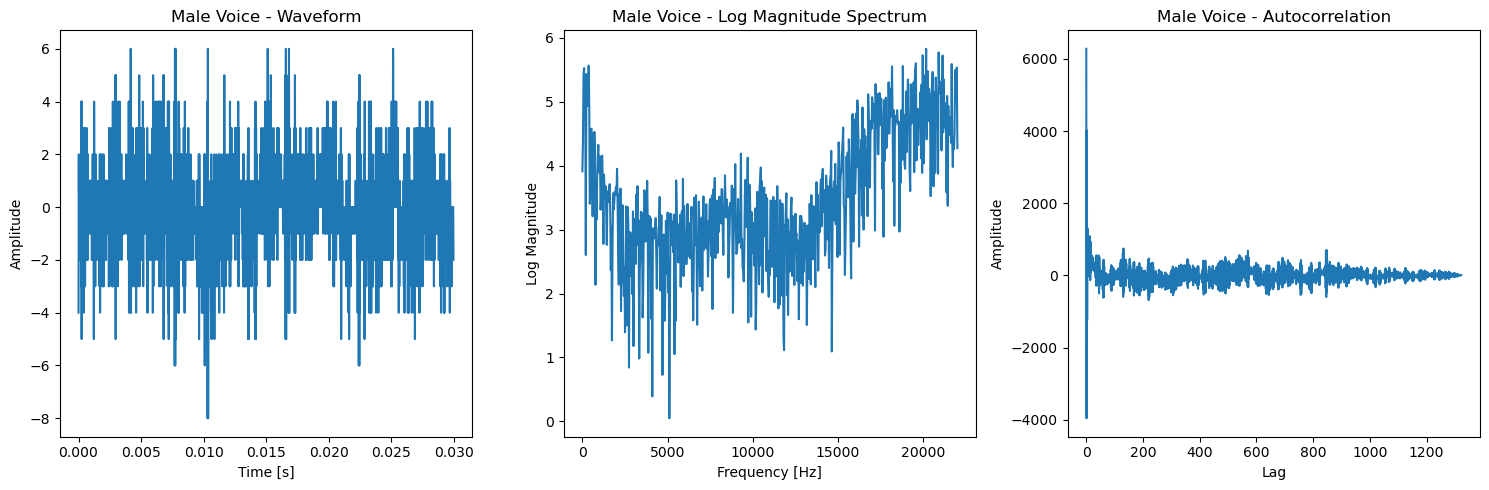

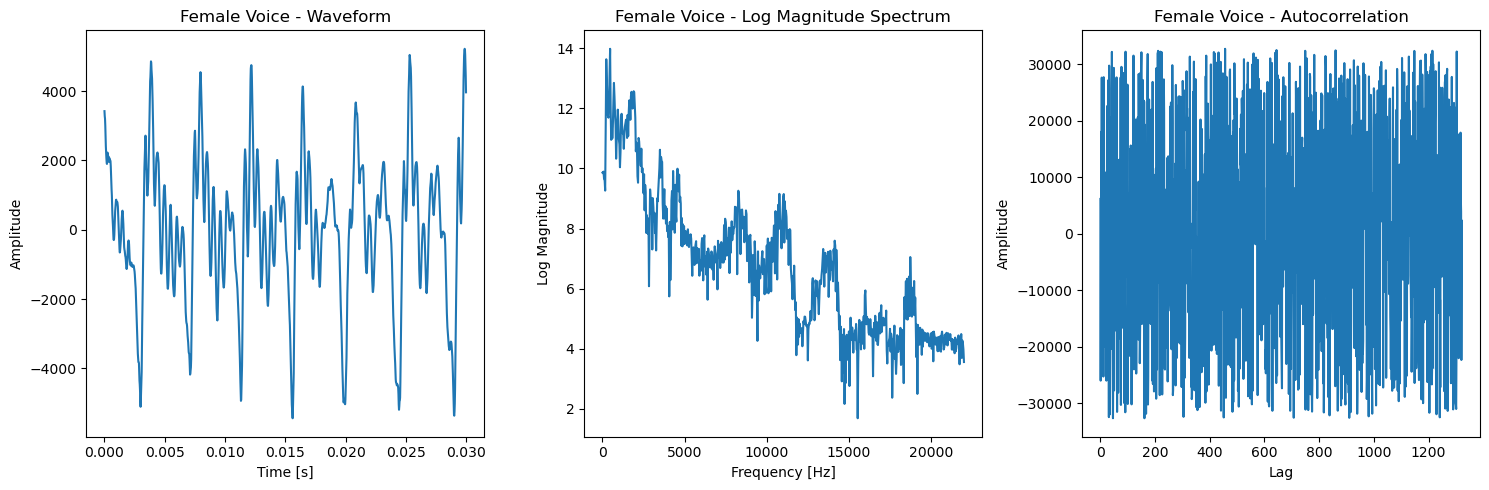

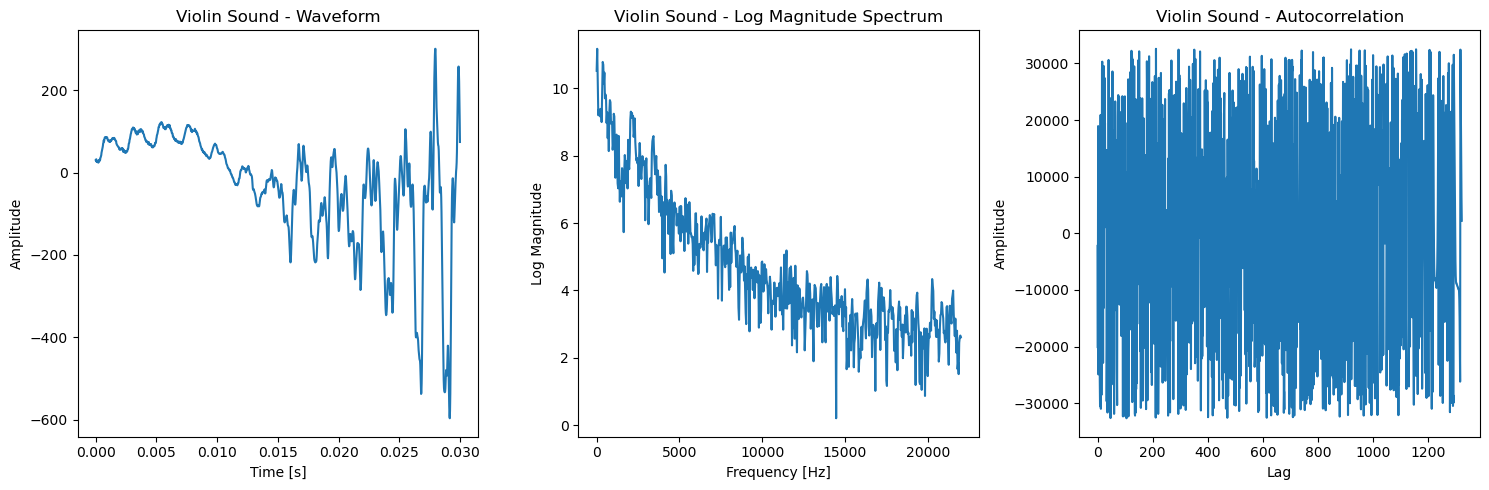

Male Pitch: 22050.00 Hz
Female Pitch: 96.71 Hz
Violin Pitch: 208.02 Hz


In [24]:


# Load audio files
male_fs, male_audio = wav.read('male.wav')
female_fs, female_audio = wav.read('female.wav')
violin_fs, violin_audio = wav.read('violin.wav')

# Extract 30ms voiced segment from each audio
male_segment = male_audio[int(0.1 * male_fs): int(0.13 * male_fs)]
female_segment = female_audio[int(0.50 * female_fs): int(0.53 * female_fs)]
violin_segment = violin_audio[int(0.03 * violin_fs): int(0.06 * violin_fs)]

# Function to plot waveform, log magnitude spectrum, and autocorrelation
def plot_graphs(audio, fs, title):
    plt.figure(figsize=(15, 5))
    
    # Time-domain waveform
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(len(audio)) / fs, audio)
    plt.title(f'{title} - Waveform')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    
    # Log magnitude spectrum
    spectrum = np.fft.fft(audio)
    freqs = np.fft.fftfreq(len(audio), 1/fs)
    plt.subplot(1, 3, 2)
    plt.plot(freqs[:len(freqs)//2], np.log(np.abs(spectrum[:len(spectrum)//2])))
    plt.title(f'{title} - Log Magnitude Spectrum')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Log Magnitude')
    
    # Autocorrelation
    autocorr = np.correlate(audio, audio, mode='full')
    autocorr = autocorr[len(audio)-1:]
    plt.subplot(1, 3, 3)
    plt.plot(autocorr)
    plt.title(f'{title} - Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()



# Function to estimate pitch using autocorrelation
def estimate_pitch(autocorr, fs):
    autocorr = autocorr[1:]
    max_lag = np.argmax(autocorr) + 1
    pitch = fs / max_lag
    return pitch

# Calculate and print pitch
male_autocorr = np.correlate(male_segment, male_segment, mode='full')[len(male_segment)-1:]
female_autocorr = np.correlate(female_segment, female_segment, mode='full')[len(female_segment)-1:]
violin_autocorr = np.correlate(violin_segment, violin_segment, mode='full')[len(violin_segment)-1:]

# Plot graphs for each audio
plot_graphs(male_segment, male_fs, 'Male Voice')
plot_graphs(female_segment, female_fs, 'Female Voice')
plot_graphs(violin_segment, violin_fs, 'Violin Sound')

male_pitch = estimate_pitch(male_autocorr, male_fs)
female_pitch = estimate_pitch(female_autocorr, female_fs)
violin_pitch = estimate_pitch(violin_autocorr, violin_fs)

print(f'Male Pitch: {male_pitch:.2f} Hz')
print(f'Female Pitch: {female_pitch:.2f} Hz')
print(f'Violin Pitch: {violin_pitch:.2f} Hz')




- Difficult to find the sweet spot for frequncies. 
- Violin >> Female >> Male

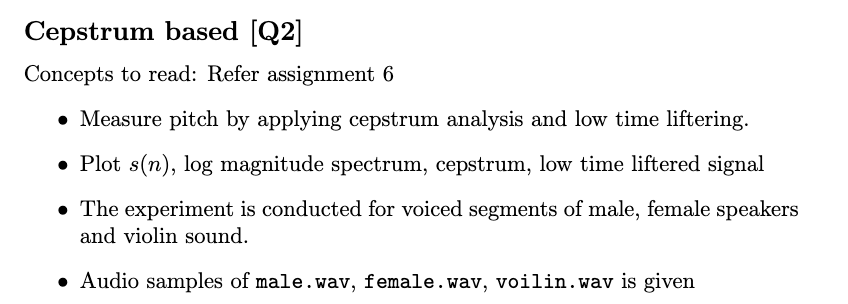